<a href="https://colab.research.google.com/github/arnku/PML/blob/main/Exam/b1_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [23]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.linalg
import scipy.spatial
import scipy.optimize as opt
import pandas as pd

In [24]:
data = np.genfromtxt('/data_part_B.csv', delimiter=',')
x_i = data[:,0]
y_i = data[:,1]
delta_i = data[:,2]
x_i_truth = x_i - delta_i

In [25]:
def gaussian_kernel(X,Xprime, gamma=2):
    dists = scipy.spatial.distance.cdist(X,Xprime,metric='sqeuclidean')
    return np.exp(-gamma*dists)

def negLogLikelihood(theta, kernel, x, y):
    noise_y = theta[0]
    gamma = theta[1:]
    # Use normalized y
    N = len(y_i)

    # Calculate K
    # Ensure X is (N,1) for kernel computation
    X_col = x.reshape(-1,1)
    K = kernel(X_col, X_col, gamma)
    Ky = K + noise_y**2 * np.eye(N)

    # Calculate Negative Log Likelihood
    # NLL = 0.5 * y.T @ Ky^-1 @ y + 0.5 * log|Ky| + N/2 * log(2pi)

    try:
        Ky_inv = np.linalg.inv(Ky)
        term1 = 0.5 * y.T @ Ky_inv @ y

        # Use slogdet for numerical stability
        sign, logdet = np.linalg.slogdet(Ky)
        if sign <= 0:
             return 1e10
        term2 = 0.5 * logdet

        term3 = 0.5 * N * np.log(2*np.pi)
        return term1 + term2 + term3
    except np.linalg.LinAlgError:
        return 1e10

def optimize_params(ranges, kernel, Ngrid, x, y):
    opt_params = opt.brute(lambda params: negLogLikelihood(params, kernel, x, y), ranges, Ns=Ngrid, finish=None)
    noise_var = opt_params[0]
    theta = opt_params[1:]
    return noise_var, theta

def conditional(X, y, X_star, noise_var, eta, kernel):
    # Ensure correct shapes
    X = X.reshape(-1, 1)
    X_star = X_star.reshape(-1, 1)

    K_xx = kernel(X, X, eta)
    K_xs = kernel(X, X_star, eta)
    K_ss = kernel(X_star, X_star, eta)

    Ky = K_xx + noise_var**2 * np.eye(len(y))
    Ky_inv = np.linalg.inv(Ky)

    mu_star = K_xs.T @ Ky_inv @ y
    sigma_star = K_ss - K_xs.T @ Ky_inv @ K_xs

    return mu_star, sigma_star

In [26]:
# sigma_y^2 is unknown and must be fit as well.
# X is given by the noisy x_i
kernel = gaussian_kernel # todo: change to new kernel
ranges = ((0.001, 10), (0.001, 10)) # todo: change to the new parameters

Ngrid = 10
noise_var_0, theta_0 = optimize_params(ranges, kernel, Ngrid, x_i, y_i)
print("optimal params:", noise_var_0, theta_0)

optimal params: 1.1119999999999999 [1.112]


In [27]:
# sigma_y^2=0.0025
# X is given by the noisy x_i
kernel = gaussian_kernel # todo: change to new kernel
ranges = ((0.05, 0.05), (0.001, 1000)) # todo: change to the new parameters

Ngrid = 10
noise_var_1, theta_1 = optimize_params(ranges, kernel, Ngrid, x_i, y_i)
print("optimal params:", noise_var_1, theta_1)

optimal params: 0.05 [111.112]


In [28]:
# sigma_y^2=0.0025
# X is given by the truth x_i ^truth = x_i - delta_i
kernel = gaussian_kernel # todo: change to new kernel
ranges = ((0.05, 0.05), (0.001, 1000)) # todo: change to the new parameters

Ngrid = 10
noise_var_2, theta_2 = optimize_params(ranges, kernel, Ngrid, x_i_truth, y_i)
print("optimal params:", noise_var_2, theta_2)

optimal params: 0.05 [111.112]


In [29]:
def plot_target():
  f = lambda x: -x**2 + 2* 1/(1 + np.exp(-10*x))
  x = np.linspace(-1,1, num=100)
  plt.plot(x, f(x))
  plt.show()

def plot_estimate(noise_var, theta, x_i, y_i, title=""):
  f = lambda x: -x**2 + 2* 1/(1 + np.exp(-10*x))
  x_star = np.linspace(-1,1, num=100)
  mu_star, sigma_star = conditional(x_i, y_i, x_star, noise_var, theta, kernel)
  mu_star.shape
  lower_error_bound = mu_star - np.diag(np.sqrt(sigma_star))*1.96
  upper_error_bound = mu_star + np.diag(np.sqrt(sigma_star))*1.96
  plt.plot(x_star, f(x_star), label="ground truth")
  plt.plot(x_star, mu_star, label="mean")
  plt.scatter(x_i, y_i, label="data")
  plt.fill_between(x_star, lower_error_bound, upper_error_bound, alpha=0.5, label="95% confidence interval")
  plt.title(title)
  plt.grid()
  plt.legend()



/tmp/ipython-input-3726753464.py:12: RuntimeWarning: invalid value encountered in sqrt
  lower_error_bound = mu_star - np.diag(np.sqrt(sigma_star))*1.96
/tmp/ipython-input-3726753464.py:13: RuntimeWarning: invalid value encountered in sqrt
  upper_error_bound = mu_star + np.diag(np.sqrt(sigma_star))*1.96


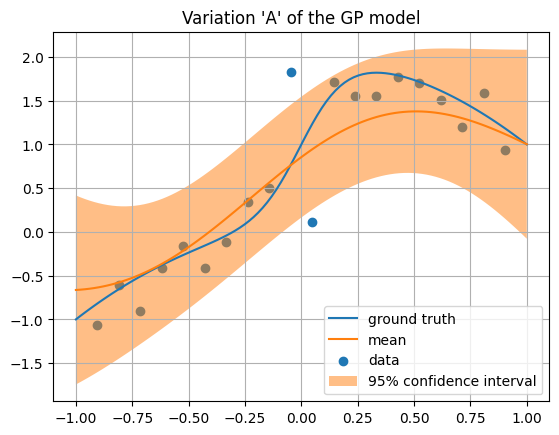

In [30]:
plot_estimate(noise_var_0, theta_0, x_i, y_i, "Variation 'A' of the GP model")

/tmp/ipython-input-3726753464.py:12: RuntimeWarning: invalid value encountered in sqrt
  lower_error_bound = mu_star - np.diag(np.sqrt(sigma_star))*1.96
/tmp/ipython-input-3726753464.py:13: RuntimeWarning: invalid value encountered in sqrt
  upper_error_bound = mu_star + np.diag(np.sqrt(sigma_star))*1.96


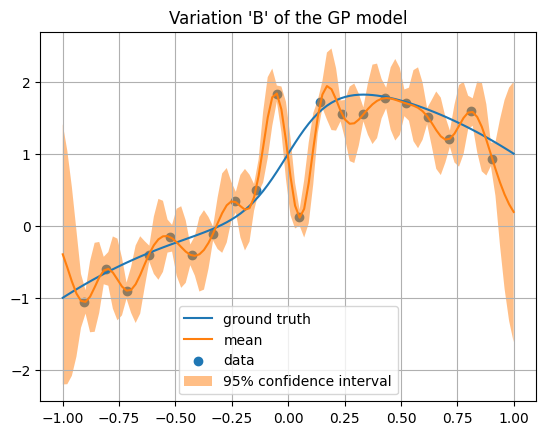

In [31]:
# the ground truth function we want to learn
plot_estimate(noise_var_1, theta_1, x_i, y_i, "Variation 'B' of the GP model")

/tmp/ipython-input-3726753464.py:12: RuntimeWarning: invalid value encountered in sqrt
  lower_error_bound = mu_star - np.diag(np.sqrt(sigma_star))*1.96
/tmp/ipython-input-3726753464.py:13: RuntimeWarning: invalid value encountered in sqrt
  upper_error_bound = mu_star + np.diag(np.sqrt(sigma_star))*1.96


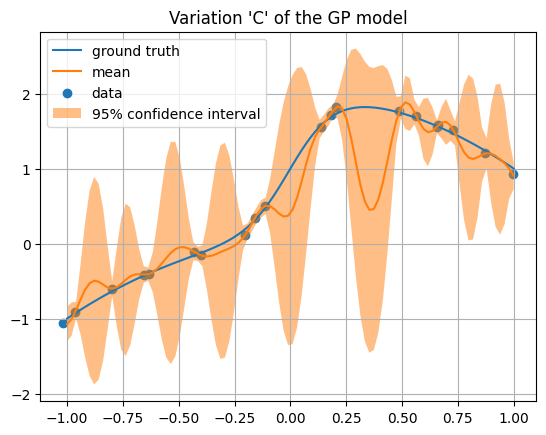

In [32]:
plot_estimate(noise_var_2, theta_2, x_i_truth, y_i, "Variation 'C' of the GP model")